In [4]:
import sys
sys.path.append("..")
import NEW_LIB as lib

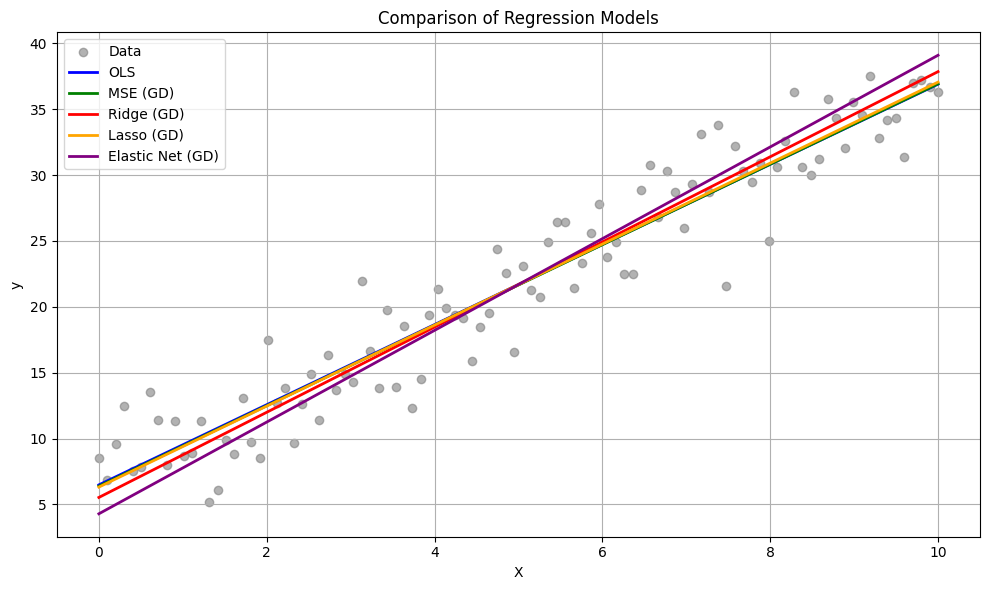

OLS Coefficients: [3.0413798] Intercept: 6.481561437767951
MSE Coefficients: [3.05394135] Intercept: 6.384169050018719
Ridge Coefficients: [3.2320006] Intercept: 5.527569016121891
Lasso Coefficients: [3.07390334] Intercept: 6.3138129147162525
Elastic Net Coefficients: [3.48022946] Intercept: 4.287171360114385


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Generate toy data ---
np.random.seed(42)
X = np.linspace(0, 10, 100)
y = 3 * X + 7 + np.random.randn(100) * 3  # y = 3x + 7 + noise

# --- Convert to pandas for compatibility ---
X_df = pd.DataFrame(X, columns=["feature"])
y_df = pd.Series(y, name="target")

# --- Initialize and Fit Models ---
ols_model = lib.OLS_regression().fit(X_df, y_df)
mse_model = lib.MSE_regression().set_params(learning_rate=0.01, epochs=1000).fit(X_df, y_df)
ridge_model = lib.Ridge_regression().set_params(lambda_=0.5, learning_rate=0.01, epochs=1000).fit(X_df, y_df)
lasso_model = lib.Lasso_regression().set_params(lambda_=0.5, learning_rate=0.01, epochs=1000).fit(X_df, y_df)
elastic_net_model = lib.ElasticNet_regression().set_params(lambda1=1, lambda2=0.5, learning_rate=0.01, epochs=1000).fit(X_df, y_df)

# --- Make Predictions ---
x_test = np.linspace(0, 10, 100)
x_test_df = pd.DataFrame(x_test, columns=["feature"])

y_pred_ols = ols_model.predict(x_test_df)
y_pred_mse = mse_model.predict(x_test_df)
y_pred_ridge = ridge_model.predict(x_test_df)
y_pred_lasso = lasso_model.predict(x_test_df)
y_pred_elastic_net = elastic_net_model.predict(x_test_df)

# --- Plot Results ---
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="gray", label="Data", alpha=0.6)
plt.plot(x_test, y_pred_ols, label="OLS", color="blue", linewidth=2)
plt.plot(x_test, y_pred_mse, label="MSE (GD)", color="green", linewidth=2)
plt.plot(x_test, y_pred_ridge, label="Ridge (GD)", color="red", linewidth=2)
plt.plot(x_test, y_pred_lasso, label="Lasso (GD)", color="orange", linewidth=2)
plt.plot(x_test, y_pred_elastic_net, label="Elastic Net (GD)", color="purple", linewidth=2)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("Comparison of Regression Models")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Metrics ---
print("OLS Coefficients:", ols_model.coefficients, "Intercept:", ols_model.intercept)
print("MSE Coefficients:", mse_model.coefficients, "Intercept:", mse_model.intercept)
print("Ridge Coefficients:", ridge_model.coefficients, "Intercept:", ridge_model.intercept)
print("Lasso Coefficients:", lasso_model.coefficients, "Intercept:", lasso_model.intercept)
print("Elastic Net Coefficients:", elastic_net_model.coefficients, "Intercept:", elastic_net_model.intercept)


In [16]:
ols_model.coefficients[0]
ols_model.metrics['significance']

,feature,coefficient,t_stat,p_value
0,X0,3.04138,64.676558,0.0
